# Magentic Resonance Phenotyping Analysis Functions

## Library and function imports

In [1]:
# imports for data processing, exploratory analysis, and statistics
from __future__ import print_function
import sys
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import scipy.stats as stats
import collections
from collections import Counter
import statsmodels.stats.multitest as multitest
from matplotlib_venn import venn2

## Significant feature discovery

In [2]:
###### function to compare two groups of animals (case/control)
### function to pull from radiomics data .csv file and perform analysis (t-test, l2fc, multiple comparisons correction)
### outputs csv files and prints how many significant features

# library imports from sklearn
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.feature_selection import VarianceThreshold

# savePath1, savePath2 (str) - parent directory for location of raw data and comparisons folder for each animal, image, and region of interest,
# r (str) - name of region of interest to locate
# csvHeader (str) - label for the .csv file to be created
# f (str) - name of feature or transformation type to analyze 
# alpha (int) - alpha level for multiple hypothesis testing
# multipletest (str) - name of fdr correction as defined in multitest from statsmodels.stats package
# animal1, path1 (str) - name of animal and path to .csv radiomics data (numerator)
# animal2, path2  (str) - name of animal and path to .csv radiomics data (denominator)
# minmax (boolean) - perform minmax scaling (default = True)
# save (boolean) - save dataframes into comparisons folder (default = False)

def two_groups_feature_analysis_byclass(savePath1, savePath2, r, csvHeader, f, alpha, multipletest, animal1, path1, animal2, path2, minmax=True, save=False):
    
    # generate string of the comparison performed 
    compare_path = "_".join([path1,path2])
    
    # create directory/save location for the comparison that is to be performed 
    d_directory = os.path.join(savePath1, 'comparisons', compare_path)
    if not os.path.exists(d_directory):
        os.makedirs(d_directory)
    
    # creates dataframe for first csv to compare against 
    csv_name = (path1 + '.csv')
    csv_path = os.path.join(savePath1, 'PyRadiomics_raw_data', csv_name)
    pre_a = pd.read_csv(csv_path).set_index('filename')
    
    # creates dataframe for second csv to compare against 
    csv_name = (path2 + '.csv')
    csv_path = os.path.join(savePath2, 'PyRadiomics_raw_data', csv_name)
    pre_b = pd.read_csv(csv_path).set_index('filename')

    # create data frame for data analysis
    l2fc_df = pd.DataFrame()

    # filter and create new data frames for specific feature class
    feature_class_reg = f
    a = pre_a.filter(regex=feature_class_reg)
    b = pre_b.filter(regex=feature_class_reg)
    
    if f == 'original':
        # drop diagnostics
        diagnostics_cols = a.filter(like='diagnostics').columns
        a = a.drop(diagnostics_cols,axis=1)
        b = b.drop(diagnostics_cols,axis=1)

    #find the features that DO NOT have the exact same values for all replicates in both cases and controls
        ### this should essentially remove zero variance features that persist 

    threshold1 = VarianceThreshold(threshold=0.0)
    threshold1.fit(a)

    constant_columns1 = [column for column in a.columns if column not in a.columns[threshold1.get_support()]]


    threshold2 = VarianceThreshold(threshold=0.0)
    threshold2.fit(b)
    constant_columns2 = [column for column in b.columns if column not in b.columns[threshold2.get_support()]]

    #define a case and control dataset consisting only of differing features as defined above
    drop_columns = set(constant_columns1).intersection(constant_columns2)

    clean_a = a.drop(drop_columns, axis=1)
    clean_b = b.drop(drop_columns,axis=1)

#     perform minmax scaling on all inputted data 
    if minmax==True:
        # insert tag column to denote the different dataframes
        clean_a.insert(0,'tag',0)
        clean_b.insert(0,'tag',1)
        
        # combine the two dataframes 
        new_df = pd.concat([clean_a,clean_b]).reset_index(drop=True)
        
        # save list of the column names
        col_n = list(new_df.columns)
        
        # initiate minmax scaler
        mm_scaler = MinMaxScaler()
        
        # fit and scale the columns of all the data 
        df_scaled = mm_scaler.fit_transform(new_df)
        
        # redefine the scaled dataframe to have the same columns as the original dataframe 
        df_scaled = pd.DataFrame(df_scaled, columns=col_n)
        
        # split the data back into the original two dataframes after minmax scaling using the tag
        minmax_a = df_scaled[df_scaled.tag ==0]
        minmax_b = df_scaled[df_scaled.tag == 1]
        
        # remove tag columns from both dataframes before further processing 
        clean_a = minmax_a.drop('tag',axis=1)
        clean_b = minmax_b.drop('tag',axis=1)

    #find the mean for each feature for both cases and controls
    mean_a = clean_a.apply(np.mean,axis=0)
    mean_b = clean_b.apply(np.mean,axis=0)
    
    #calculate log 2 fold change (case/control) of all features with non-zero variance in dataset
   
    ## calculation only meaningful if minmax is performed, otherwise there will be logs of negative values taken 
    l2fc_mean_a_b = np.log2(mean_a/mean_b)

    #perform t-test on all features
    t_stat, p_val = stats.ttest_ind(clean_a,clean_b,axis=0)

    #perform FDR BH correction on t-test p-values; 
    # produces 4 values;: an array of booleans for rejecting null hypothesis, an array of corrected p_vals, 
    # the corrected alpha for Sidak Method, and corrected alpha for Bonferroni method
    reject_hypothesis, pvals_corrected, alphacSidak, alphacBonf = multitest.multipletests(p_val,alpha=alpha,method=multipletest)

    #Define columns in l2fc_df, make sure index for the dataframe is appropriate
    l2fc_df[path1] = mean_a
    l2fc_df[path2] = mean_b
    l2fc_df['L2FC'] =l2fc_mean_a_b
    l2fc_df['p_val'] = p_val
    l2fc_df[multipletest+'_adjusted_p_val'] = pvals_corrected
    l2fc_df['roi'] = r
    l2fc_df['animal_1'] = animal1
    l2fc_df['animal_2'] = animal2

    #Create location to save file; have different names if they are minmax'd or not
    
    if minmax == True:
        save_file_loc = os.path.join(savePath1,'comparisons',compare_path,'minmax_'+csvHeader+r+'_'+f+'_l2fc_'+compare_path+'_'+multipletest+'.csv')
    else:
        save_file_loc = os.path.join(savePath1,'comparisons',compare_path,csvHeader+r+'_'+f+'_l2fc_'+compare_path+'_'+multipletest+'.csv')
    
    #Save dataframe of mean scores, l2fc, pvalues, corrected pvalues to a .csv file; sort by fdr_adjusted_p_val
    if save == True:
        l2fc_df.sort_values(multipletest+'_adjusted_p_val', ascending=True).to_csv(save_file_loc)
    
    #spot check to see if there are any significant features after FDR correction
    print(f+'_'+r+'_'+compare_path+': ' + str(sum(reject_hypothesis)) +' significant features after ' +multipletest+' correction')
    
    # returns log two fold change comparison dataframe and dataframes for each dataset after they were cleaned for comparison
    return l2fc_df, clean_a, clean_b
    



## Generate Feature Table

In [2]:
 
# define radiomics feature names as a dataframe for the feature table function to use 
raw_df = pd.DataFrame()

# load list of features into a dataframe 
ftr_loc = os.path.join('..','radiomics_features_list', 'radiomics_features_list.csv')
ftr_df = pd.read_csv(ftr_loc).set_index('feature_name')
ftr_df = ftr_df.T

# l_compare_path (str) - name of the comparison used in the two groups feature analysis by class function 
# multipletest (str) - name of the multipletest correctino method used in the two groups feature analysis by class function 
# alpha (int) - threshold level of significance for tests performed
# p, i, r, t (str)  - parameter (binWidth), image type, region of interest, transformation type to analyze
# ftr_df (pandas dataframe) - dataframe with list of all feature names calculated by pyradiomics 
# rad_data (str) - defines the name of the directory where the log two fold analysis data was saved

def feature_table(l_compare_path, multipletest, alpha,p,i,r,t,ftr_df=ftr_df,rad_data='radiomics_data'):
    feature_classes = ['firstorder', 'glcm', 'glszm', 'glrlm', 'gldm']

    # filter for transformation class from the feature list dataframe
    transformation_class = t
    filter_df = pd.DataFrame()
    filter_df = ftr_df.filter(regex=transformation_class)
    filter_df = filter_df.T
    filter_df = filter_df.reset_index()

    # define new dataframe
    raw_df = pd.DataFrame()
    
    roiPath = os.path.join('..', rad_data, p, i, r)
    save_file_loc = os.path.join(roiPath,'comparisons',l_compare_path,
                                 "_".join(['minmax',p,i,r,t,'l2fc',l_compare_path,multipletest])+'.csv')

    # load comparison data from the two groups feature analysis by class function
    raw_df = pd.read_csv(save_file_loc)
    # rename columns, remove columns
    raw_df.rename(columns={'Unnamed: 0': 'feature_name',raw_df.columns[1]: 'case',raw_df.columns[2]:'control' }, inplace=True)
    raw_df.drop( ['animal_1', 'animal_2', 'roi'], inplace=True, axis=1)

    # combine filtered dataframe with two gropus feature analysis by class dataframe
    csv_df = pd.merge(filter_df, raw_df, on = 'feature_name', how = 'left')

    # define new column names for the test p-values
    signif_col_name = multipletest + '_significance_alpha_' + str(alpha)
    adj_p_val_name = multipletest + '_adjusted_p_val'

    # define columns within new dataframe
    csv_df['image_type'] = i
    csv_df['param_type'] = p
    csv_df['roi'] = r
    csv_df['transformation_type'] = t
    csv_df['feature_class'] = ''
    csv_df['feature_type'] = csv_df['feature_name'].str.split('_').str[2:].str.join('')
    csv_df[signif_col_name] = ''

    # for each feature class, make clean feature class names
    for f in feature_classes:
        csv_df['feature_class'][csv_df['feature_name'].str.contains(f+'_')] = f

    # fill all na p-values with 1
    csv_df[adj_p_val_name].fillna(1.0, inplace=True)
    csv_df['p_val'].fillna(1.0, inplace=True)

    # define significance by adjusted p-value level 
    csv_df[signif_col_name][csv_df[adj_p_val_name] <= 0.05] = True
    csv_df[signif_col_name][csv_df[adj_p_val_name] > 0.05] = False

    # return large dataframe contianing significance level for each feature in each region of interest for each transformation for each image type for each binWidth tested
    return csv_df 



## Generate heatmap from feature table

In [4]:



# list of all columns in the feature table dataframe in order as produced by pyradiomics
# list to be used to generate label locations and markers
columns = ['original_firstorder_10Percentile', 'original_firstorder_90Percentile',
       'original_firstorder_Energy', 'original_firstorder_Entropy',
       'original_firstorder_InterquartileRange',
       'original_firstorder_Kurtosis', 'original_firstorder_Maximum',
       'original_firstorder_Mean', 'original_firstorder_MeanAbsoluteDeviation',
       'original_firstorder_Median', 'original_firstorder_Minimum',
       'original_firstorder_Range',
       'original_firstorder_RobustMeanAbsoluteDeviation',
       'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness',
       'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity',
       'original_firstorder_Variance', 'original_glcm_Autocorrelation',
       'original_glcm_ClusterProminence', 'original_glcm_ClusterShade',
       'original_glcm_ClusterTendency', 'original_glcm_Contrast',
       'original_glcm_Correlation', 'original_glcm_DifferenceAverage',
       'original_glcm_DifferenceEntropy', 'original_glcm_DifferenceVariance',
       'original_glcm_Id', 'original_glcm_Idm', 'original_glcm_Idmn',
       'original_glcm_Idn', 'original_glcm_Imc1', 'original_glcm_Imc2',
       'original_glcm_InverseVariance', 'original_glcm_JointAverage',
       'original_glcm_JointEnergy', 'original_glcm_JointEntropy',
       'original_glcm_MCC', 'original_glcm_MaximumProbability',
       'original_glcm_SumAverage', 'original_glcm_SumEntropy',
       'original_glcm_SumSquares', 'original_gldm_DependenceEntropy',
       'original_gldm_DependenceNonUniformity',
       'original_gldm_DependenceNonUniformityNormalized',
       'original_gldm_DependenceVariance',
       'original_gldm_GrayLevelNonUniformity',
       'original_gldm_GrayLevelVariance',
       'original_gldm_HighGrayLevelEmphasis',
       'original_gldm_LargeDependenceEmphasis',
       'original_gldm_LargeDependenceHighGrayLevelEmphasis',
       'original_gldm_LargeDependenceLowGrayLevelEmphasis',
       'original_gldm_LowGrayLevelEmphasis',
       'original_gldm_SmallDependenceEmphasis',
       'original_gldm_SmallDependenceHighGrayLevelEmphasis',
       'original_gldm_SmallDependenceLowGrayLevelEmphasis',
       'original_glrlm_GrayLevelNonUniformity',
       'original_glrlm_GrayLevelNonUniformityNormalized',
       'original_glrlm_GrayLevelVariance',
       'original_glrlm_HighGrayLevelRunEmphasis',
       'original_glrlm_LongRunEmphasis',
       'original_glrlm_LongRunHighGrayLevelEmphasis',
       'original_glrlm_LongRunLowGrayLevelEmphasis',
       'original_glrlm_LowGrayLevelRunEmphasis', 'original_glrlm_RunEntropy',
       'original_glrlm_RunLengthNonUniformity',
       'original_glrlm_RunLengthNonUniformityNormalized',
       'original_glrlm_RunPercentage', 'original_glrlm_RunVariance',
       'original_glrlm_ShortRunEmphasis',
       'original_glrlm_ShortRunHighGrayLevelEmphasis',
       'original_glrlm_ShortRunLowGrayLevelEmphasis',
       'original_glszm_GrayLevelNonUniformity',
       'original_glszm_GrayLevelNonUniformityNormalized',
       'original_glszm_GrayLevelVariance',
       'original_glszm_HighGrayLevelZoneEmphasis',
       'original_glszm_LargeAreaEmphasis',
       'original_glszm_LargeAreaHighGrayLevelEmphasis',
       'original_glszm_LargeAreaLowGrayLevelEmphasis',
       'original_glszm_LowGrayLevelZoneEmphasis',
       'original_glszm_SizeZoneNonUniformity',
       'original_glszm_SizeZoneNonUniformityNormalized',
       'original_glszm_SmallAreaEmphasis',
       'original_glszm_SmallAreaHighGrayLevelEmphasis',
       'original_glszm_SmallAreaLowGrayLevelEmphasis',
       'original_glszm_ZoneEntropy', 'original_glszm_ZonePercentage',
       'original_glszm_ZoneVariance']

# algorithimically define length of each feature type and create distance markers for feature heatmap figure using list of columns
len_firstorder = len([x for x in columns if 'firstorder' in x])
len_glcm = len([x for x in columns if 'glcm' in x])
len_gldm = len([x for x in columns if 'gldm' in x])
len_glrlm =len([x for x in columns if 'glrlm' in x])
len_glszm = len([x for x in columns if 'glszm' in x])

# define locations of the edge and label for each feature type region for the heatmap
edge_firstorder = len_firstorder
label_firstorder = edge_firstorder/2.0

edge_glcm = edge_firstorder + len_glcm
label_glcm = edge_firstorder + len_glcm/2.0

edge_gldm = edge_glcm + len_gldm
label_gldm = edge_glcm + len_gldm/2.0

edge_glrlm = edge_gldm + len_glrlm
label_glrlm = edge_gldm + len_glrlm/2.0

edge_glszm = edge_glrlm + len_glszm
label_glszm = edge_glrlm + len_glszm/2.0

# define y-coordinate of the markers and the text used for labeling the heatmap along x-axis
marker_y = 6.3
text_y = 6.5

# red is positive, blue is negative
default_cmap = sns.color_palette(['blue','gray', 'red'])



# define heatmap function 

# df (pandas dataframe) - dataframe generated from feature_table function
# i, p, t (str) - refers to image type, parameter type, and transformation type as defined in the feature table dataframe
# title (str) - title for heatmap
# figsize (integer tuple) - width and height in inches of figure
# cmap (seaborn color_palette) - define color map of hetmap
# xlabel (str) - x-axis label
# ylabel (str) - y-axis label
# side_marker_x (int) - x-coordinate for y-axis additional labels
# side_marker1_y, side_marker2_y (int) - y-coordinate for y-axis additional labels (e.g. region of interest hemisphere labels)
# side_center_marker_y (int) - y-coordinate for dividing marker between hemispheres
# yticklabs (array of strings) - y-axis tick labels
# save (boolean) - if True, saves figure to results_directory
# results directory (str) - path to directory to save figure
# dpi (int) - resolution of figure in dots per inch

def feature_heatmap(df, i, p, t,  title,  figsize=(20,3), cmap=default_cmap, xlabel='',ylabel='Region of Interest', 
                    side_marker_x=-7.5, side_marker1_y = 1.5, side_marker2_y=4.5, side_center_marker_y =2.9, yticklabs=None, 
                    save=False, results_directory=None,  dpi=300):

    # generate new column in inputted feature table dataframe that captures the sign and direction of the log two fold change of significant features
    direction = (np.sign(df['L2FC'].fillna(0.0)) * df['fdr_bh_significance_alpha_0.05'])
    df['direction'] = direction

    # subset dataframe for particular image, paramter, and transformation type of interest
    binWidth_df = df[(df.image_type == i) & (df.param_type == p) & (df.transformation_type == t)].fillna(False)
    
    # convert dataframe into pivot table, pivoting feature names and their significant log two fold change directionality by region of interest 
    result = binWidth_df.pivot_table(index='roi',columns='feature_name', values='direction', fill_value=0)
    
    # define figure, axis, and its size
    fig, ax = plt.subplots(figsize=figsize)
    
    # generate heatmap
    if yticklabs==None:
        # with defeault yticklabels
        sns.heatmap(result, vmin=-1, vmax=1, cmap=cmap, linewidths=.1, cbar=False, ax=ax,xticklabels='')
    else: 
        # with user inputted yticklabels
        sns.heatmap(result, vmin=-1, vmax=1, cmap=cmap, linewidths=.1, cbar=False, ax=ax,xticklabels='', yticklabels=yticklabs)

    # label the heatmap
    
    # label hemispheres of ROIs with dividing mark
    plt.text(side_marker_x,side_marker1_y, 'Left', ha='center', rotation = 90)
    plt.text(side_marker_x, side_marker2_y, 'Right', ha='center', rotation=90)
    plt.text(0,side_center_marker_y, '|', ha='center', rotation=90, fontdict={'weight':'bold'})

    # label each feature type using location and names as defined above 
    ax.text(0.05,marker_y, '|', ha='center', fontdict={'weight':'bold'})
    ax.text(edge_firstorder,marker_y, '|', ha='center', fontdict={'weight':'bold'})
    ax.text(label_firstorder,text_y, 'First Order Features', ha='center')

    ax.text(edge_glcm,marker_y, '|', ha='center', fontdict={'weight':'bold'})
    ax.text(label_glcm ,text_y, 'GLCM Features',ha='center')

    ax.text(edge_gldm,marker_y, '|', ha='center', fontdict={'weight':'bold'})
    ax.text(label_gldm,text_y, 'GLDM Features', ha='center')

    ax.text(edge_glrlm,marker_y, '|', ha='center', fontdict={'weight':'bold'})
    ax.text(label_glrlm ,text_y, 'GLRLM Features',ha='center')

    ax.text(edge_glszm,marker_y, '|', ha='center', fontdict={'weight':'bold'})
    ax.text(label_glszm ,text_y, 'GLSZM Features',ha='center')
    
    # label plot with title and image type
    plt.title("_".join([title,i]))
    # label x axis
    plt.xlabel(xlabel,rotation=0)
    # label y axis
    plt.ylabel(ylabel)
    
    # save file to inputted results directory
    if save==True:
        # create file name from title and image type
        plot_file_name = "_".join([title,i])+'.png'
        # generate path to save figure at 
        plot_path = os.path.join(results_directory, plot_file_name)
        # save figure at inputted dpi value
        plt.savefig(plot_path, bbox_inches='tight', dpi=dpi)


## Jaccard similarity calculation

In [3]:
# df1, df2 (pandas dataframe) - dataframe generated from feature_table function
# roi1, roi2 (str) - name of ROI to analyze from each dataframe respectively
# image (str) - image type to analyze (as defined in the feature table data frame)
# parameter (str) - parameter type for the radiomics data (as defined in the feature table data frame)
# transformation (str) - transformation type for the radiomics data (as defined in feature table dataframe)

def feature_jaccard_score(df1, df2, roi1, roi2, image, parameter, transformation):
    
    # determine directionality of log two fold change
    direction1 = (np.sign(df1['L2FC'].fillna(0.0)) * df1['fdr_bh_significance_alpha_0.05'])
    # save as new column
    df1['direction'] = direction1
    # subset dataframe by image, parameter, and transformation type
    subset_df1 = df1[(df1.image_type == image) & (df1.param_type == parameter) & (df1.transformation_type == transformation)].fillna(False)
    # remap boolean to integer to ensure ease of calculations
    subset_df1['fdr_bh_significance_alpha_0.05'] = subset_df1['fdr_bh_significance_alpha_0.05'].astype(int)           
    # create pivot table of the subset_df
    pivot_df1 = subset_df1.pivot_table(index='roi',columns='feature_name', values='direction', fill_value=0)
    # subset_pivot table for ROI of interest
    a = pivot_df1.loc[roi1,:]
    
    # perform same operations as above on the second dataframe for which to compare against
    direction2 = (np.sign(df2['L2FC'].fillna(0.0)) * df2['fdr_bh_significance_alpha_0.05'])
    df2['direction'] = direction2
    subset_df2 = df2[(df2.image_type == image) & (df2.param_type == parameter) & (df2.transformation_type == transformation)].fillna(False)
    subset_df2['fdr_bh_significance_alpha_0.05'] = subset_df2['fdr_bh_significance_alpha_0.05'].astype(int)           
    pivot_df2 = subset_df2.pivot_table(index='roi',columns='feature_name', values='direction', fill_value=0)
    b = pivot_df2.loc[roi2,:]

    # create new dataframe to compare the two MRP signatures of interest
    compare = pd.DataFrame([a,b]).T
    compare.columns = ['1','2']
    
    # remove feautres that are not statistically significant in either signature
    filterOutM00 =  abs(compare).sum(axis=1) > 0
    filtered_compare = compare[filterOutM00]

    # determine all significant features that have the same value across the two signatures being compared
    booleanM11 = filtered_compare['1'] == filtered_compare['2']
    
    # calculate the Jaccard score by dividing the number of significant features of the same value by the full set of significant features across the two signatures
    jaccardNumerator = sum(booleanM11)
    jaccardDenominator = filtered_compare.shape[0]
    
    if (jaccardDenominator == 0) | (jaccardNumerator == 0):
        jaccardScore = 0
        print('Numerator and/or denominator equals 0. Jaccard score will equal 0')
    
    else:
        jaccardScore = jaccardNumerator/jaccardDenominator

    return jaccardScore

## Generate volcano plot from feature table

In [8]:
# df (pandas dataframe) - dataframe generated from feature_table function
# param, image, roi, transform (str) - refers to parameter type, image type, region of interest, and transformation type as defined in the feature table dataframe
# label (str) - title for volcano plot
# animal (str) - name of animal analyzed (default = '')
# save (boolean) - if True, saves figure to results_animal/volcano_plots/label.png (default = False)
# show (boolean) - if True, displays plot within notebook (default = True)
# threshold (integer tuple) - defines l2fc cut-off value to be plotted as vertical dotted lines (default = (-1,1))
# style (str) - seaborn style for plot (default = 'darkgrid')
# context (str) - seaborn context for plot (default = 'notebook')
# figsize (integer tuple) - width and height in inches of figure
# size (int) - size of dots plotted
# dpi (int) - resolution of figure in dots per inch

def volcanoPlot(df,param,image,roi,transform,label, animal='',save=False, show=True, 
                threshold=(-1,1),style='darkgrid',context='notebook', figsize=(6,5),size=15,dpi=300):
    
    # establish plot style 
    sns.set_style(style)
    sns.set_context(context)

    # filter feature table for specific data to plot as volcano plot
    df = df[(df.roi == roi) & (df.image_type == image) & (df.param_type == param) & (df.transformation_type == transform)].fillna(False)

    # clean dataframe if reloaded from a .csv file
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns={'Unnamed: 0'})
    
    # define figure size
    plt.figure(figsize=figsize)

    # create -log10 pval to plot on volcano y-axis
    df['-log10_p_val'] = -np.log10(df['p_val'])
    
    # find the top features
    top_feats = df[df.fdr_bh_adjusted_p_val <= 0.05]
    
    # if top features exist, plot them 
    if not top_feats.empty:
        # increase in value 
        up_feats = top_feats[top_feats.L2FC > 0]
        # decrease in value
        down_feats = top_feats[top_feats.L2FC < 0]
        
        # find number of features up and down 
        num_up = up_feats.shape[0]
        num_down = down_feats.shape[0]
        
        # redefine the original df without the top features for later plotting
        df = df.drop(top_feats.index)
        
        # plot the down features as red
        down = sns.scatterplot(data=down_feats,x='L2FC',y='-log10_p_val',color='blue', s=size,label='Significantly down (n='+str(num_down)+')')
        # plot the up features as  green 
        up = sns.scatterplot(data=up_feats,x='L2FC',y='-log10_p_val',color='red',s=size, label='Significantly up (n='+str(num_up)+')')
        
        # plot the -log10 p val threshold (this value will vary for each volcano plot because the FDR BH procedure produces the cutoff value based on p-value ranking rather than a set cut off value)
        plt.axhline(min(top_feats['-log10_p_val']),ls='--',lw=1)
    
    # find number of not significant features
    num_not_sig = df.shape[0]
    
    # plot non significant features
    not_sig = sns.scatterplot(data=df,x='L2FC',y='-log10_p_val',color='k', s=size, label='Not significant (n='+str(num_not_sig)+')') 
    
    # plot l2fc threshold value as defined in function call
    for val in threshold:
        plt.axvline(val,ls='--', lw=1)
    
    # create legend 
    plt.legend(bbox_to_anchor=(1.05,1),loc='upper left')
    
    # label plot 
    plt.title(label)
    plt.ylabel('-log10(p-value)')
    plt.xlabel('log2(Fold Change)')
    
    # define yaxis, xaxis range 
    plt.ylim(0,5)
    plt.xlim(-6,6)
    
    # save file in results/volcano_plots directory 
    if save==True:
        plt.savefig(os.path.join('../results/'+animal+'/volcano_plots/',label+'.png'),
                   bbox_inches='tight', dpi=dpi)
    # print plot to notebook 
    if show==True:
        plt.show()
    # returns !!! 
    return df, top_feats

# An example MRP analysis

## Feature discovery

In [6]:
# perform significant feature discovery and log two fold change analysis for described regions of interest for data processed at bin width of 0.1 for each image type
# perform log two fold change comparison on data using for loop to define the datasets


# define the regions of interest  
roi = ['r_amygdala', 'r_hippocampus', 'r_globus_pallidus_caudate_putamen', 
       'l_amygdala','l_hippocampus','l_globus_pallidus_caudate_putamen']

# define the transformation/feature classes to perform the comparison on
transformation_classes = ['original']
# define the binWidths for which to perform the comparisons
param_types = ['binWidth_0_05','binWidth_0_075', 'binWidth_0_1', 'binWidth_0_25','binWidth_0_5','binWidth_1']

# define the images to perform analysis on 
image_types = ['ODI','NDI', 'vISO']

# variables for path1 define the nuemrator dataset; variables for path2 define the denominator dataset for the l2fc 
# define sex 
path1_sex = ['male']
path2_sex = ['male']

#define day 
path1_day = ['P45']
path2_day = ['P45']

# define animal type
path1_animal = ['nrxn']
path2_animal = ['control']


# loop to  create paths to appropriate data iteratively, pass the paths into the function 
for p in param_types:
    for i in image_types:
        # define portion of label for the .csv file to be created
        csv_name_heading = p + '_' + i + '_'
        for r in roi:
            for transform in transformation_classes:
                # use zips to iteratively define the comparisons desired 
                for sex1, sex2 in zip(path1_sex,path2_sex):
                    
                    for animal1, animal2 in zip(path1_animal,path2_animal):
                        # creates path to the location where the comparisons folder will be created
                        savePath1 = os.path.join('..', "_".join(['radiomics_data',animal1]), p, i, r)
                        savePath2 = os.path.join('..', "_".join(['radiomics_data',animal2]), p, i, r)
                        
                        for day1, day2 in zip(path1_day, path2_day):
                            animal1_name = "_".join([sex1,day1,animal1])
                            animal2_name = "_".join([sex2, day2,animal2])

                            data_1 = "_".join([p,i, animal1_name])
                            data_2 = "_".join([p,i, animal2_name])

                            # save the cleaned (and minmax'd) dataframes into case, control and the comparison output as l2fc
                            l2fc, case, control = two_groups_feature_analysis_byclass(savePath1, savePath2, r, csv_name_heading, transform,
                                                               0.05, 'fdr_bh', animal1_name, data_1, animal2_name, data_2 ,minmax=True,save=True)

original_r_amygdala_binWidth_0_05_ODI_male_P45_nrxn_binWidth_0_05_ODI_male_P45_control: 0 significant features after fdr_bh correction
original_r_hippocampus_binWidth_0_05_ODI_male_P45_nrxn_binWidth_0_05_ODI_male_P45_control: 61 significant features after fdr_bh correction
original_r_globus_pallidus_caudate_putamen_binWidth_0_05_ODI_male_P45_nrxn_binWidth_0_05_ODI_male_P45_control: 0 significant features after fdr_bh correction
original_l_amygdala_binWidth_0_05_ODI_male_P45_nrxn_binWidth_0_05_ODI_male_P45_control: 0 significant features after fdr_bh correction
original_l_hippocampus_binWidth_0_05_ODI_male_P45_nrxn_binWidth_0_05_ODI_male_P45_control: 0 significant features after fdr_bh correction
original_l_globus_pallidus_caudate_putamen_binWidth_0_05_ODI_male_P45_nrxn_binWidth_0_05_ODI_male_P45_control: 0 significant features after fdr_bh correction
original_r_amygdala_binWidth_0_05_NDI_male_P45_nrxn_binWidth_0_05_NDI_male_P45_control: 0 significant features after fdr_bh correction
or

/opt/conda/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


original_r_globus_pallidus_caudate_putamen_binWidth_0_05_vISO_male_P45_nrxn_binWidth_0_05_vISO_male_P45_control: 27 significant features after fdr_bh correction
original_l_amygdala_binWidth_0_05_vISO_male_P45_nrxn_binWidth_0_05_vISO_male_P45_control: 0 significant features after fdr_bh correction
original_l_hippocampus_binWidth_0_05_vISO_male_P45_nrxn_binWidth_0_05_vISO_male_P45_control: 0 significant features after fdr_bh correction


/opt/conda/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


original_l_globus_pallidus_caudate_putamen_binWidth_0_05_vISO_male_P45_nrxn_binWidth_0_05_vISO_male_P45_control: 0 significant features after fdr_bh correction
original_r_amygdala_binWidth_0_075_ODI_male_P45_nrxn_binWidth_0_075_ODI_male_P45_control: 0 significant features after fdr_bh correction
original_r_hippocampus_binWidth_0_075_ODI_male_P45_nrxn_binWidth_0_075_ODI_male_P45_control: 56 significant features after fdr_bh correction
original_r_globus_pallidus_caudate_putamen_binWidth_0_075_ODI_male_P45_nrxn_binWidth_0_075_ODI_male_P45_control: 0 significant features after fdr_bh correction
original_l_amygdala_binWidth_0_075_ODI_male_P45_nrxn_binWidth_0_075_ODI_male_P45_control: 0 significant features after fdr_bh correction
original_l_hippocampus_binWidth_0_075_ODI_male_P45_nrxn_binWidth_0_075_ODI_male_P45_control: 0 significant features after fdr_bh correction
original_l_globus_pallidus_caudate_putamen_binWidth_0_075_ODI_male_P45_nrxn_binWidth_0_075_ODI_male_P45_control: 0 significan

/opt/conda/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


original_r_globus_pallidus_caudate_putamen_binWidth_0_075_vISO_male_P45_nrxn_binWidth_0_075_vISO_male_P45_control: 0 significant features after fdr_bh correction
original_l_amygdala_binWidth_0_075_vISO_male_P45_nrxn_binWidth_0_075_vISO_male_P45_control: 0 significant features after fdr_bh correction
original_l_hippocampus_binWidth_0_075_vISO_male_P45_nrxn_binWidth_0_075_vISO_male_P45_control: 0 significant features after fdr_bh correction
original_l_globus_pallidus_caudate_putamen_binWidth_0_075_vISO_male_P45_nrxn_binWidth_0_075_vISO_male_P45_control: 0 significant features after fdr_bh correction


/opt/conda/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


original_r_amygdala_binWidth_0_1_ODI_male_P45_nrxn_binWidth_0_1_ODI_male_P45_control: 0 significant features after fdr_bh correction
original_r_hippocampus_binWidth_0_1_ODI_male_P45_nrxn_binWidth_0_1_ODI_male_P45_control: 55 significant features after fdr_bh correction
original_r_globus_pallidus_caudate_putamen_binWidth_0_1_ODI_male_P45_nrxn_binWidth_0_1_ODI_male_P45_control: 3 significant features after fdr_bh correction
original_l_amygdala_binWidth_0_1_ODI_male_P45_nrxn_binWidth_0_1_ODI_male_P45_control: 0 significant features after fdr_bh correction
original_l_hippocampus_binWidth_0_1_ODI_male_P45_nrxn_binWidth_0_1_ODI_male_P45_control: 0 significant features after fdr_bh correction
original_l_globus_pallidus_caudate_putamen_binWidth_0_1_ODI_male_P45_nrxn_binWidth_0_1_ODI_male_P45_control: 0 significant features after fdr_bh correction
original_r_amygdala_binWidth_0_1_NDI_male_P45_nrxn_binWidth_0_1_NDI_male_P45_control: 0 significant features after fdr_bh correction
original_r_hippo

/opt/conda/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


original_r_amygdala_binWidth_0_1_vISO_male_P45_nrxn_binWidth_0_1_vISO_male_P45_control: 0 significant features after fdr_bh correction
original_r_hippocampus_binWidth_0_1_vISO_male_P45_nrxn_binWidth_0_1_vISO_male_P45_control: 0 significant features after fdr_bh correction


/opt/conda/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


original_r_globus_pallidus_caudate_putamen_binWidth_0_1_vISO_male_P45_nrxn_binWidth_0_1_vISO_male_P45_control: 0 significant features after fdr_bh correction
original_l_amygdala_binWidth_0_1_vISO_male_P45_nrxn_binWidth_0_1_vISO_male_P45_control: 2 significant features after fdr_bh correction
original_l_hippocampus_binWidth_0_1_vISO_male_P45_nrxn_binWidth_0_1_vISO_male_P45_control: 0 significant features after fdr_bh correction


/opt/conda/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


original_l_globus_pallidus_caudate_putamen_binWidth_0_1_vISO_male_P45_nrxn_binWidth_0_1_vISO_male_P45_control: 0 significant features after fdr_bh correction
original_r_amygdala_binWidth_0_25_ODI_male_P45_nrxn_binWidth_0_25_ODI_male_P45_control: 0 significant features after fdr_bh correction
original_r_hippocampus_binWidth_0_25_ODI_male_P45_nrxn_binWidth_0_25_ODI_male_P45_control: 36 significant features after fdr_bh correction
original_r_globus_pallidus_caudate_putamen_binWidth_0_25_ODI_male_P45_nrxn_binWidth_0_25_ODI_male_P45_control: 0 significant features after fdr_bh correction
original_l_amygdala_binWidth_0_25_ODI_male_P45_nrxn_binWidth_0_25_ODI_male_P45_control: 0 significant features after fdr_bh correction
original_l_hippocampus_binWidth_0_25_ODI_male_P45_nrxn_binWidth_0_25_ODI_male_P45_control: 0 significant features after fdr_bh correction
original_l_globus_pallidus_caudate_putamen_binWidth_0_25_ODI_male_P45_nrxn_binWidth_0_25_ODI_male_P45_control: 0 significant features aft

/opt/conda/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


original_r_amygdala_binWidth_0_25_vISO_male_P45_nrxn_binWidth_0_25_vISO_male_P45_control: 0 significant features after fdr_bh correction
original_r_hippocampus_binWidth_0_25_vISO_male_P45_nrxn_binWidth_0_25_vISO_male_P45_control: 0 significant features after fdr_bh correction


/opt/conda/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


original_r_globus_pallidus_caudate_putamen_binWidth_0_25_vISO_male_P45_nrxn_binWidth_0_25_vISO_male_P45_control: 0 significant features after fdr_bh correction
original_l_amygdala_binWidth_0_25_vISO_male_P45_nrxn_binWidth_0_25_vISO_male_P45_control: 0 significant features after fdr_bh correction
original_l_hippocampus_binWidth_0_25_vISO_male_P45_nrxn_binWidth_0_25_vISO_male_P45_control: 0 significant features after fdr_bh correction


/opt/conda/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


original_l_globus_pallidus_caudate_putamen_binWidth_0_25_vISO_male_P45_nrxn_binWidth_0_25_vISO_male_P45_control: 0 significant features after fdr_bh correction
original_r_amygdala_binWidth_0_5_ODI_male_P45_nrxn_binWidth_0_5_ODI_male_P45_control: 0 significant features after fdr_bh correction
original_r_hippocampus_binWidth_0_5_ODI_male_P45_nrxn_binWidth_0_5_ODI_male_P45_control: 65 significant features after fdr_bh correction
original_r_globus_pallidus_caudate_putamen_binWidth_0_5_ODI_male_P45_nrxn_binWidth_0_5_ODI_male_P45_control: 0 significant features after fdr_bh correction
original_l_amygdala_binWidth_0_5_ODI_male_P45_nrxn_binWidth_0_5_ODI_male_P45_control: 0 significant features after fdr_bh correction
original_l_hippocampus_binWidth_0_5_ODI_male_P45_nrxn_binWidth_0_5_ODI_male_P45_control: 75 significant features after fdr_bh correction
original_l_globus_pallidus_caudate_putamen_binWidth_0_5_ODI_male_P45_nrxn_binWidth_0_5_ODI_male_P45_control: 0 significant features after fdr_bh

/opt/conda/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


original_r_hippocampus_binWidth_0_5_vISO_male_P45_nrxn_binWidth_0_5_vISO_male_P45_control: 0 significant features after fdr_bh correction


/opt/conda/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


original_r_globus_pallidus_caudate_putamen_binWidth_0_5_vISO_male_P45_nrxn_binWidth_0_5_vISO_male_P45_control: 0 significant features after fdr_bh correction
original_l_amygdala_binWidth_0_5_vISO_male_P45_nrxn_binWidth_0_5_vISO_male_P45_control: 0 significant features after fdr_bh correction
original_l_hippocampus_binWidth_0_5_vISO_male_P45_nrxn_binWidth_0_5_vISO_male_P45_control: 0 significant features after fdr_bh correction


/opt/conda/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


original_l_globus_pallidus_caudate_putamen_binWidth_0_5_vISO_male_P45_nrxn_binWidth_0_5_vISO_male_P45_control: 0 significant features after fdr_bh correction
original_r_amygdala_binWidth_1_ODI_male_P45_nrxn_binWidth_1_ODI_male_P45_control: 0 significant features after fdr_bh correction
original_r_hippocampus_binWidth_1_ODI_male_P45_nrxn_binWidth_1_ODI_male_P45_control: 14 significant features after fdr_bh correction
original_r_globus_pallidus_caudate_putamen_binWidth_1_ODI_male_P45_nrxn_binWidth_1_ODI_male_P45_control: 0 significant features after fdr_bh correction
original_l_amygdala_binWidth_1_ODI_male_P45_nrxn_binWidth_1_ODI_male_P45_control: 0 significant features after fdr_bh correction
original_l_hippocampus_binWidth_1_ODI_male_P45_nrxn_binWidth_1_ODI_male_P45_control: 10 significant features after fdr_bh correction
original_l_globus_pallidus_caudate_putamen_binWidth_1_ODI_male_P45_nrxn_binWidth_1_ODI_male_P45_control: 0 significant features after fdr_bh correction
original_r_amy

/opt/conda/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


original_l_amygdala_binWidth_1_NDI_male_P45_nrxn_binWidth_1_NDI_male_P45_control: 0 significant features after fdr_bh correction
original_l_hippocampus_binWidth_1_NDI_male_P45_nrxn_binWidth_1_NDI_male_P45_control: 2 significant features after fdr_bh correction


/opt/conda/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


original_l_globus_pallidus_caudate_putamen_binWidth_1_NDI_male_P45_nrxn_binWidth_1_NDI_male_P45_control: 0 significant features after fdr_bh correction
original_r_amygdala_binWidth_1_vISO_male_P45_nrxn_binWidth_1_vISO_male_P45_control: 0 significant features after fdr_bh correction
original_r_hippocampus_binWidth_1_vISO_male_P45_nrxn_binWidth_1_vISO_male_P45_control: 0 significant features after fdr_bh correction


/opt/conda/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


original_r_globus_pallidus_caudate_putamen_binWidth_1_vISO_male_P45_nrxn_binWidth_1_vISO_male_P45_control: 0 significant features after fdr_bh correction
original_l_amygdala_binWidth_1_vISO_male_P45_nrxn_binWidth_1_vISO_male_P45_control: 0 significant features after fdr_bh correction
original_l_hippocampus_binWidth_1_vISO_male_P45_nrxn_binWidth_1_vISO_male_P45_control: 1 significant features after fdr_bh correction
original_l_globus_pallidus_caudate_putamen_binWidth_1_vISO_male_P45_nrxn_binWidth_1_vISO_male_P45_control: 0 significant features after fdr_bh correction


/opt/conda/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Table of features

In [4]:
# generate feature table containing all analyzed data including significance levels for each feature and region of interest for all image types analyzed

# define the dataframe to append each run of feature table for each region of interest, transformation, parameter, and image type tested
final_table_df = pd.DataFrame()

# defining arrays and variables to be used in the itereative function call 
roi_list = ['r_amygdala', 'r_hippocampus', 'r_globus_pallidus_caudate_putamen',
       'l_amygdala','l_hippocampus','l_globus_pallidus_caudate_putamen']

transformation_types = ['original']        

param_type = ['binWidth_0_05',
               'binWidth_0_075', 'binWidth_0_1',
               'binWidth_0_25','binWidth_0_5',
               'binWidth_1']
image_type = ['ODI','NDI','vISO']

multipletest = 'fdr_bh'
alpha = 0.05

# define paths to create the comparison path which defines location of the two groups feature analysis by class file created
path1_sex = 'male'
path2_sex = 'male'
path1_day = 'P45'
path2_day = 'P45'
path1_animal = 'nrxn'
path2_animal = 'control'

for i in image_type:
    for p in param_type:
        csvHeader = p + '_' + i + '_'
        l_path1 = "_".join([p,i,path1_sex,path1_day,path1_animal])
        l_path2 = "_".join([p,i,path2_sex,path2_day,path2_animal])
        l_compare_path = "_".join([l_path1,l_path2])
        for r in roi_list:
            maskROI = r
            
            
            for t in transformation_types:
                df = feature_table(l_compare_path, multipletest, alpha,p,i,r,t,ftr_df=ftr_df, rad_data='radiomics_data_nrxn')
                final_table_df = final_table_df.append(df, ignore_index=True)

<ipython-input-2-6e9ad287c6f1>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  csv_df['feature_class'][csv_df['feature_name'].str.contains(f+'_')] = f
<ipython-input-2-6e9ad287c6f1>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  csv_df[signif_col_name][csv_df[adj_p_val_name] <= 0.05] = True
<ipython-input-2-6e9ad287c6f1>:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  csv_df[signif_col_name][csv_df[adj_p_val_name] > 0.05] = Fals

In [5]:
# save final_table_df as .csv file in /results/nrxn/feature_table
final_table_df.to_csv('../results/nrxn/feature_table/nrxn_feature_table.csv')

## MRP signature

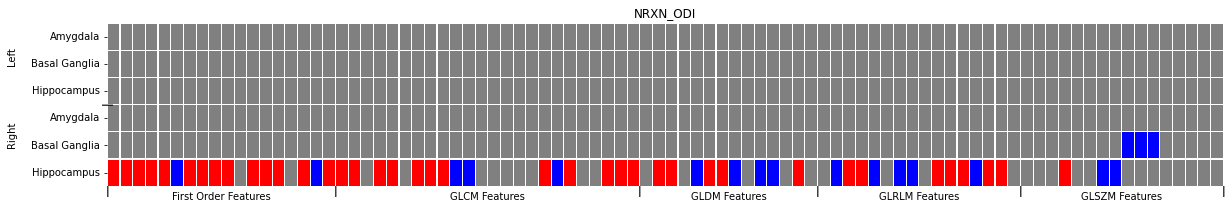

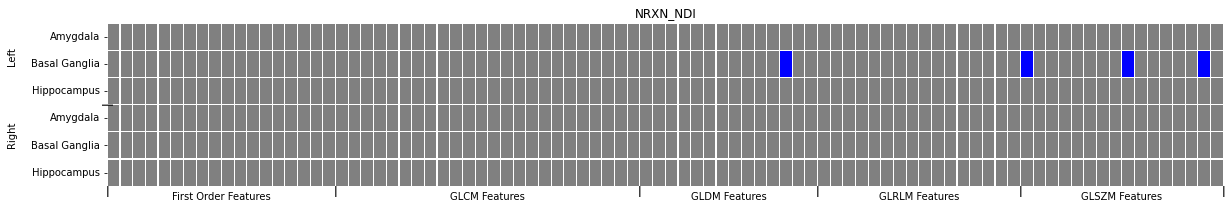

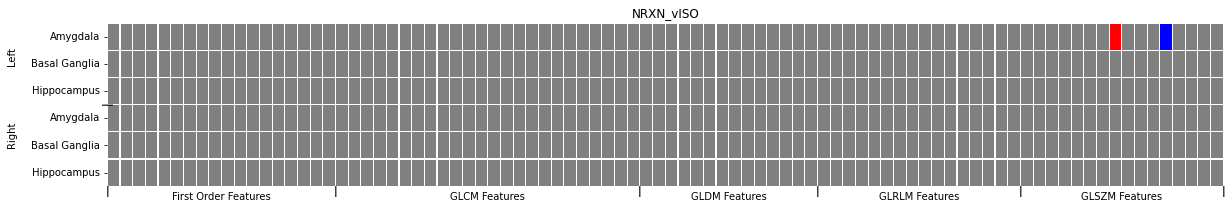

In [9]:
# generate heatmaps for NODDI signal (NDI, ODI, vISO) using the original feature transformationsfor data proceassed at bin width of 0.1 

# define feature table generated from previous step as df
df = final_table_df

# define transformation types, parameter types, and image types to visualize
transformation_types = ['original']

param_type = ['binWidth_0_1']

image_type = ['ODI', 'NDI','vISO']

# provide custom y-tick labels for the regins of interest
yticklabs = ['Amygdala','Basal Ganglia', 'Hippocampus', 'Amygdala','Basal Ganglia', 'Hippocampus']

for p in param_type:
    for i in image_type:
            for t in transformation_types:
                feature_heatmap(df, i , p , t,  'NRXN', save=True, results_directory='../results/nrxn/mrp_signature', yticklabs=yticklabs,ylabel='')

## Jaccard score for two ROIs in the ODI image

In [8]:
# using df from previous cell, compute the jaccard score of two ROIs from that dataframe 
# this function can be used with two different dataframes (e.g. Nrxn vs Disc1) if that comparison is of interest
r1 = 'r_hippocampus'
r2 = 'l_hippocampus'
img = 'ODI'
param = 'binWidth_0_1'
trans = 'original'
feature_jaccard_score(df, df, r1, r2, img, param, trans)

Numerator and/or denominator equals 0. Jaccard score will equal 0


0

## Volcano plot of MRP signature for an ROI

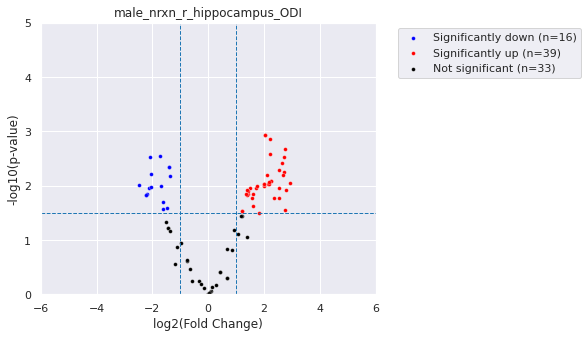

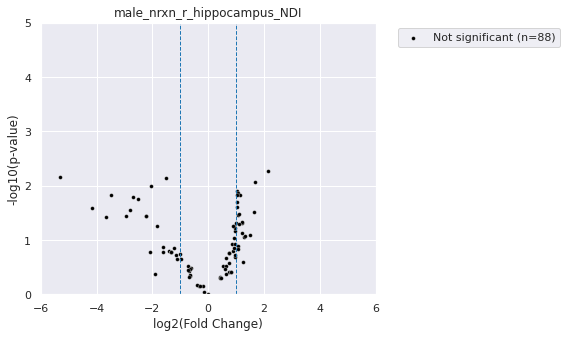

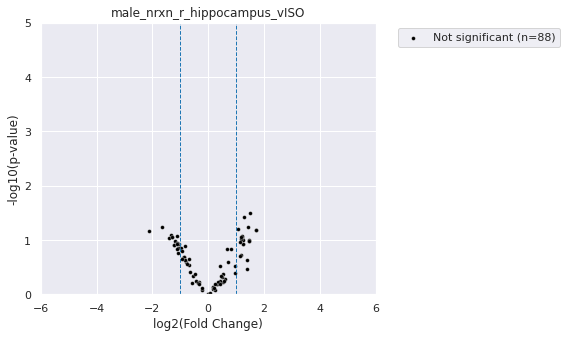

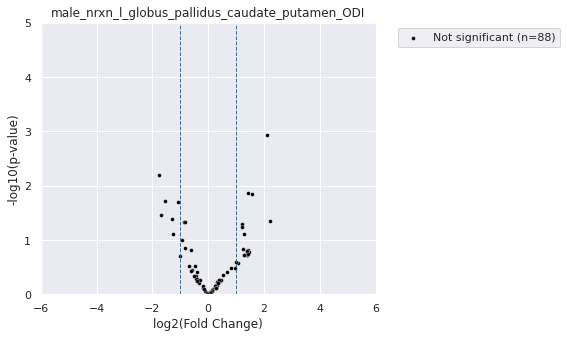

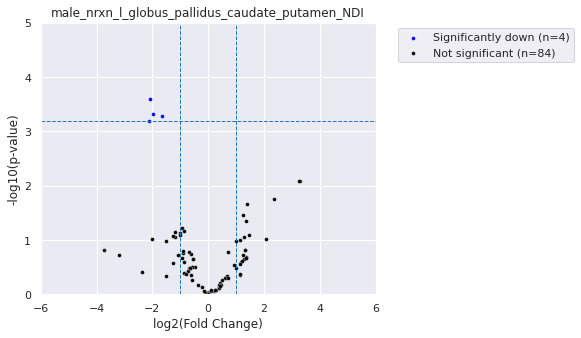

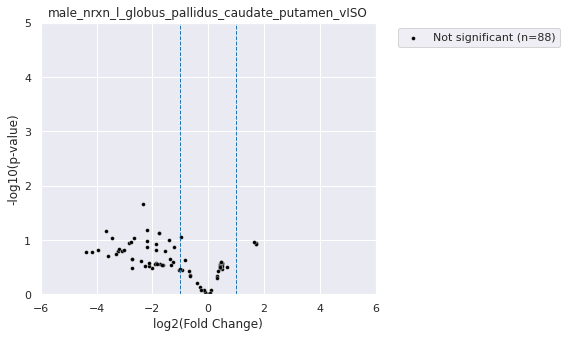

In [11]:
# define list of ROI's to visualize
roi = ['r_hippocampus', 'l_globus_pallidus_caudate_putamen',]
# define transformation type, parameter typee, and image type to analyze
transformation_types = ['original']
param_type = ['binWidth_0_1']
image_type = ['ODI','NDI','vISO']

 

# use feature table (previously dfined as final_table_df) to generate the data
feature_table = final_table_df

# list animal type that is the numerator for the feature table for generating label/title of volcano plot
animal1 = 'nrxn'

for r in roi:
    for image in image_type:
        for param in param_type:
            for transform in transformation_types:
                label = "_".join([sex1,animal1,r,image])

                new,top = volcanoPlot(feature_table,param,image,r,transform,label, animal=animal1, save=True, show=True, 
                threshold=(-1,1),style='darkgrid',context='notebook', figsize=(6,5),size=15)
                